# XML example and exercise
****
+ study examples of accessing nodes in XML tree structure  
+ work on exercise to be completed and submitted
****
+ reference: https://docs.python.org/2.7/library/xml.etree.elementtree.html
+ data source: http://www.dbis.informatik.uni-goettingen.de/Mondial
****

In [1]:
from xml.etree import ElementTree as ET

## XML example

+ for details about tree traversal and iterators, see https://docs.python.org/2.7/library/xml.etree.elementtree.html

In [2]:
document_tree = ET.parse( './data/mondial_database_less.xml' )

In [3]:
# print names of all countries
for child in document_tree.getroot():
    print(child.find('name').text)

Albania
Greece
Macedonia
Serbia
Montenegro
Kosovo
Andorra


In [4]:
# print names of all countries and their cities
for element in document_tree.iterfind('country'):
    print('* ' + element.find('name').text + ':')
    capitals_string = ''
    for subelement in element.getiterator('city'):
        capitals_string += subelement.find('name').text + ', '
    print(capitals_string[:-2])

* Albania:
Tirana, Shkodër, Durrës, Vlorë, Elbasan, Korçë
* Greece:
Komotini, Kavala, Athina, Peiraias, Peristeri, Acharnes, Patra, Kozani, Kerkyra, Ioannina, Thessaloniki, Iraklio, Chania, Ermoupoli, Rhodes, Tripoli, Lamia, Chalkida, Larissa, Volos, Mytilini, Karyes
* Macedonia:
Skopje, Kumanovo
* Serbia:
Beograd, Novi Sad, Niš
* Montenegro:
Podgorica
* Kosovo:
Prishtine
* Andorra:
Andorra la Vella


****
## XML exercise

Using data in 'data/mondial_database.xml', the examples above, and refering to https://docs.python.org/2.7/library/xml.etree.elementtree.html, find

1. 10 countries with the lowest infant mortality rates
2. 10 cities with the largest population
3. 10 ethnic groups with the largest overall populations (sum of best/latest estimates over all countries)
4. name and country of a) longest river, b) largest lake and c) airport at highest elevation

In [5]:
# Load xml file
database_xml = ET.parse( './data/mondial_database.xml' )

In [6]:
import pandas as pd
import numpy as np

****
## Question 1: 10 countries with the lowest infant mortality rates
   
Process:  
a. Examine the data to find under which feature name is the infant mortality stored.   
b. Iterate through all the countries and retrieve the data.   
c. Converte the retrieved data into a Pandas DataFrame for manipulation.
d. Sort the dataframe in ascending order.

After review of the XML file, it appears that the infant mortality rate is stored using the element name infant_mortality.

In [7]:
# Storage variables.
infantMortRates_dict = {}

# Retrieve data by iteration.
for country in database_xml.iterfind('country'):
    infantMortRates_dict[country.findtext('name')] = country.findtext('infant_mortality')

# Convert dictionary into Pandas DataFrame.
infantMortRates_df = pd.DataFrame({'infant_mortality':infantMortRates_dict})

# Examine the data
infantMortRates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, Afghanistan to Zimbabwe
Data columns (total 1 columns):
infant_mortality    228 non-null object
dtypes: object(1)
memory usage: 3.8+ KB


In [8]:
# The dataframe contains null values, they are dropped before the data is sorted.
infantMortRates_df = infantMortRates_df.dropna()
print("The 10 countries with the lowest infant mortality rate (excluding missing data) are:\n")
infantMortRates_df.sort_values(by='infant_mortality').head(10)

The 10 countries with the lowest infant mortality rate (excluding missing data) are:



,infant_mortality
Monaco,1.81
Romania,10.16
Fiji,10.2
Brunei,10.48
Grenada,10.5
Mauritius,10.59
Panama,10.7
Seychelles,10.77
United Arab Emirates,10.92
Barbados,10.93


****
## Question 2: 10 cities with the largest population
   
Process:  
 a. Examine the data to find under which feature name is the population.   
 b. Iterate through all the countries and retrieve the data.   
 c. Converte the retrieved data into a Pandas DataFrame for manipulation.
 d. Sort the dataframe in descendign order.

After review of the XML file, it appears that the city population is stored under several layers of elements. First the country element contains a city element, which contains a list of population elements defined by year.
When retrieving the desired data, only the most recent year is retrieved as it represents the best estimation of the current population value. In order to create a systematic process, the population for each year is retrieved and only the one corresponding to the most recent value is stored.

In [9]:
# Storage variables.
cityPopulation_dict = {}

# Retrieve data by iteration.
for country in database_xml.iterfind('country'):
    for city in country.iterfind('city'):
        try:
            popHistory = {int(population.get('year')) : population.text 
                          for population in city.iterfind('population')}
            cityPopulation_dict[city.find('name').text] = int(popHistory[max(popHistory.keys())])
        except:
            continue
            
# Convert dictionary into Pandas DataFrame.
cityPopulation_df = pd.DataFrame({'city_pop':cityPopulation_dict})

# Examine the data.
cityPopulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393 entries, Abomey-Calavi to al Hudaydah
Data columns (total 1 columns):
city_pop    393 non-null int64
dtypes: int64(1)
memory usage: 6.1+ KB


In [10]:
# The dataframe does not contain null values.
print("The 10 cities with the largest population are:\n")
cityPopulation_df.sort_values(by='city_pop',ascending=False).head(10)

The 10 cities with the largest population are:



,city_pop
Seoul,9708483
Al Qahirah,8471859
Bangkok,7506700
Hong Kong,7055071
Ho Chi Minh,5968384
Singapore,5076700
Al Iskandariyah,4123869
New Taipei,3939305
Busan,3403135
Pyongyang,3255288


****
## Question 3: 10 ethnic groups with the largest overall populations (sum of best/latest estimates over all countries)
   
Process:   
 a. Examine the data to find under which feature name contains the ethnic group population.     
 b. Iterate through all the countries and retrieve the data.  
 c. Iterate through each ethnic group per country to retrieve its population percentage.  
 d. Converte the retrieved data into a Pandas DataFrame for manipulation.  
 e. Group the results per ethnic group name.  
 f. Sort the dataframe in descendign order.  

After review of the XML file, it appears that the desired data (population of largest ethnic) group is not directly available. In order to build it, first the latest population needs to be obtained, then the percentage of the largest ethnic group needs to be extracted. Finally, the desired feature is obtained by multipling both extracted values.

In [11]:
# Storage variables.
countryPopulation_dict = {}
ethnicGroupPercent_dict = {}
ethnicGroupName_dict = {}

# Retrieve data by iteration.
for country in database_xml.iterfind('country'):
    try:
        popHistory = {int(population.get('year')) : population.text 
                      for population in country.iterfind('population')}
        countryPopulation_dict[country.find('name').text] = int(popHistory[max(popHistory.keys())])
    except:
        countryPopulation_dict[country.find('name').text] = np.nan
            
    try:
        ethnicHistory = {ethnicgroup.text: float(ethnicgroup.get('percentage'))
                         for ethnicgroup in country.iterfind('ethnicgroup')}
        
        largestEthnic = max(ethnicHistory, key=ethnicHistory.get)
        ethnicGroupPercent_dict[country.find('name').text] = ethnicHistory[largestEthnic]/100.0    
        ethnicGroupName_dict[country.find('name').text]=largestEthnic    
    except:
        ethnicGroupPercent_dict[country.find('name').text] = np.nan
        ethnicGroupName_dict[country.find('name').text]=np.nan

In [12]:
# Convert the dictionary into a Pandas dataframe.
ethnicGroupsCount_df = pd.DataFrame({"country_pop" : countryPopulation_dict,
                                "ethnic_name":ethnicGroupName_dict,
                                "ethnic_percent":ethnicGroupPercent_dict})

# Create the ethnic group population.
ethnicGroupsCount_df['ethnic_pop'] = ethnicGroupsCount_df.country_pop*ethnicGroupsCount_df.ethnic_percent
ethnicGroupsCount_df.ethnic_pop.apply(pd.to_numeric)

ethnicGroup_df = (ethnicGroupsCount_df.groupby(by='ethnic_name').sum())[['ethnic_pop']]

# Verify process.
ethnicGroup_df.head()

,ethnic_pop
ethnic_name,
African,2.550135e+08
African descent,2.831500e+03
African-white-Indian,3.530619e+05
Albanian,4.255293e+06
Alemannic,3.480420e+04


In [13]:
# Sort data by ethnic population and display the largest ten ethnic groups.
ethnicGroupTopTen_df = ethnicGroup_df.sort_values(by='ethnic_pop',ascending=False).head(10)
ethnicGroupTopTen_df

,ethnic_pop
ethnic_name,
Han Chinese,1.245059e+09
Indo-Aryan,8.718156e+08
European,4.548023e+08
African,2.550135e+08
Bengali,1.467769e+08
Mestizo,1.419729e+08
Japanese,1.265342e+08
Russian,1.146462e+08
Javanese,1.134560e+08


In [14]:
# Import library and set plot parameters
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)

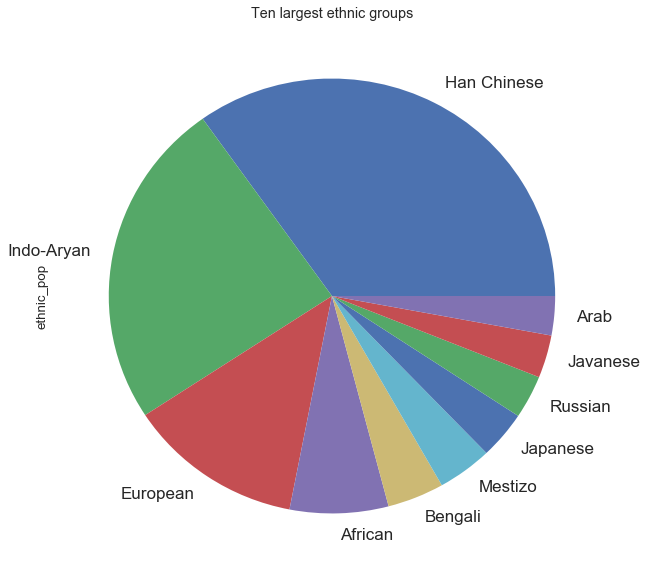

In [15]:
# Plot the data to obtain a better representation of the results
ethnicGroupTopTen_df.ethnic_pop.plot(kind='pie',
                   figsize=(10,10),
                   title="Ten largest ethnic groups",
                   fontsize=17)
plt.show()

name and country of a) longest river, b) largest lake and c) airport at highest elevation

****
## Question : Various country properties

Goal:
 Name and country of  
 a) longest river  
 b) largest lake  
 c) airport at highest elevation  
   
Process:   
 a. Examine the data to find under which feature contains the data we are looking for.   
 b. Iterate through all the countries and retrieve the data.
 c. Iterate through each subgroup per country to retrieve the data.
 d. Converte the retrieved data into a Pandas DataFrame for manipulation.
 e. Sort the dataframe in descendign order.

After review of the XML file, it appears that the desired data (population of largest ethnic) group is not directly available. In order to build it, first the latest population needs to be obtained, then the percentage of the largest ethnic group needs to be extracted. Finally, the desired feature is obtained by multipling both extracted values.

### a) Longest river

After inspecting the structure of the XML file, the rivers are listed under the main layer (as the coutries were). However, the name of the country is not directly given. Indeed, only the country code is provided.  
The first step will therefore consist of extracting a map of {Country code, Country name}. Then the river name, length and countries that it belong to are extracted.

In [16]:
# Mapping between country code and country name
# Storage variables.
countryNameCode_dict = {}

# Retrieve data by iteration.
for country in database_xml.iterfind('country'):
    try:
        countryNameCode_dict[country.attrib['car_code']] = country.find('name').text
    except:
        continue

# Test a sample record.
print(countryNameCode_dict['F'])
print(countryNameCode_dict['USA'])

France
United States


In [17]:
# River data retrieval
# Storage variables.

countryCodeCrossed_dict = {}
riverLength_dict = {}

# Retrieve data by iteration.
for river in database_xml.iterfind('river'):
    try:
        riverLength_dict[river.find('name').text] = float(river.find('length').text)
        countryCodeCrossed_dict[river.find('name').text] = river.attrib['country']
    except:
        continue

In [18]:
# Test the data
print(countryCodeCrossed_dict['Seine'])
print(riverLength_dict['Rhone'])

F
812.0


In [19]:
# Apply the mapping between the country code and name
countryNameCrossed_dict = {river:[countryNameCode_dict[code]
                                for code in codes.split(" ")] 
                           for (river, codes) in countryCodeCrossed_dict.items()}

# Join the country names for presentation.
countryNameCrossed_dict = {river:", ".join(countries) 
                           for (river,countries) in countryNameCrossed_dict.items()}

In [20]:
# Test the data
print(countryNameCrossed_dict['Rhein'])

Germany, Switzerland, Liechtenstein, Austria, France, Netherlands


In [21]:
# Convert data dictionary into a single Pandas dataframe.
riverData_df = pd.DataFrame({"river_length_km":riverLength_dict,
                                 "country_crossed":countryNameCrossed_dict})
riverData_df.head()

,country_crossed,river_length_km
Aare,Switzerland,288.0
Adda,Italy,313.0
Akagera,"Tanzania, Rwanda, Uganda",275.0
Allegheny River,United States,523.0
Aller,Germany,211.0


In [22]:
# Sort data by river length and output the first record.
riverData_df.sort_values(by='river_length_km',ascending=False).head(1)

,country_crossed,river_length_km
Amazonas,"Colombia, Brazil, Peru",6448.0


### b) Largest lake

After inspecting the structure of the XML file, the lakes are listed under the main layer (as the coutries were). However, the name of the country is not directly given. Indeed, only the country code is provided.  
The map between the country code and names from the previous question will be re-used.
Then the lake name, area, and countries that it belong to are also extracted.

In [23]:
# Lake data retrieval
# Storage variables.

countryCode_dict = {}
lakeArea_dict = {}

# Retrieve data by iteration.
for lake in database_xml.iterfind('lake'):
    try:
        lakeArea_dict[lake.find('name').text] = float(lake.find('area').text)
        countryCode_dict[lake.find('name').text] = lake.attrib['country']
    except:
        continue

In [24]:
# Test the data
print(countryCode_dict['Lake Powell'])
print(lakeArea_dict['Ammersee'])

USA
46.6


In [25]:
# Apply the mapping between the country code and name
lakeCountryName_dict = {lake:[countryNameCode_dict[code]
                                for code in codes.split(" ")] 
                           for (lake, codes) in countryCode_dict.items()}

# Join the country names for presentation.
lakeCountryName_dict = {lake:", ".join(countries) 
                           for (lake,countries) in lakeCountryName_dict.items()}

In [26]:
# Test the data
print(lakeCountryName_dict['Lake Superior'])

Canada, United States


In [27]:
# Convert data dictionary into a single Pandas dataframe.
lakeData_df = pd.DataFrame({"lake_area_km2":lakeArea_dict,
                                 "countries":lakeCountryName_dict})
lakeData_df.head()

,countries,lake_area_km2
Ammersee,Germany,46.6
Arresoe,Denmark,40.2
Atlin Lake,Canada,798.0
Balaton,Hungary,594.0
Bodensee,"Austria, Germany, Switzerland",538.5


In [28]:
# Sort data by river length and output the first record.
lakeData_df.sort_values(by='lake_area_km2',ascending=False).head(1)

,countries,lake_area_km2
Caspian Sea,"Russia, Azerbaijan, Kazakhstan, Iran, Turkmeni...",386400.0


### c) Airport at highest elevation

After inspecting the structure of the XML file, the airports are listed under the main layer (as the coutries were). However, the name of the country is not directly given. Indeed, only the country code is provided.  
The map between the country code and names from the first question will be re-used.
Then the airport name, city, IATA code, elevation, and country that it belong to are also extracted.

In [29]:
# Airport data retrieval
# Storage variables.

airportCountryCode_dict = {}
airportCity_dict = {}
airportElevation_dict = {}
airportIataCode_dict = {}

# Retrieve data by iteration.
for airport in database_xml.iterfind('airport'):
    try:
        airportCountryCode_dict[airport.find('name').text] = airport.attrib['country']
        airportCity_dict[airport.find('name').text] = airport.attrib['city']
        airportElevation_dict[airport.find('name').text] = float(airport.find('elevation').text)
        airportIataCode_dict[airport.find('name').text] = airport.attrib['iatacode']
    except:
        continue

In [30]:
# Test the data
print(airportCountryCode_dict['General Edward Lawrence Logan Intl'])
print(airportCity_dict['General Edward Lawrence Logan Intl'])
print(airportElevation_dict['General Edward Lawrence Logan Intl'])
print(airportIataCode_dict['General Edward Lawrence Logan Intl'])

USA
cty-United-States-21
6.0
BOS


In [31]:
# Apply the mapping between the country code and name
airportCountryCode_dict = {airport:countryNameCode_dict[code.strip()] 
                           for (airport, code) in airportCountryCode_dict.items()}


In [32]:
# Test the data
print(airportCountryCode_dict['General Edward Lawrence Logan Intl'])

United States


In [33]:
# Convert data dictionary into a single Pandas dataframe.
airportData_df = pd.DataFrame({"elevation_m":airportElevation_dict,
                               "IATA_code":airportIataCode_dict,
                               "city":airportCity_dict,
                               "countries":airportCountryCode_dict})
airportData_df.head()

,IATA_code,city,countries,elevation_m
A Coruna,LCG,cty-Spain-19,Spain,99.0
Aalborg,AAL,stadt-Aalborg-DK-DK,Denmark,3.0
Aarhus,AAR,stadt-Aarhus-DK-DK,Denmark,25.0
Abadan,ABD,cty-Iran-53,Iran,6.0
Abakan,ABA,cty-Russia-112,Russia,253.0


In [34]:
# Sort data by airport elevation and output the first record.
airportData_df.sort_values(by='elevation_m',ascending=False).head(1)

,IATA_code,city,countries,elevation_m
El Alto Intl,LPB,cty-BOL-1,Bolivia,4063.0
